<a href="https://colab.research.google.com/github/gil612/PyTorch/blob/main/09_pytorch_model_deployment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 09. PyTorch Model Deployment
What is model deployment?
Machine Learning model deployment is the act of making your machine learning model(s) available to someone or something else.


## 0. Get Setup

In [1]:
# For this notebook to run with updated APIs, we need torch 1.12+ and torchvision 0.13+
try:
    import torch
    import torchvision
    assert int(torch.__version__.split(".")[1]) >= 12, "torch version should be 1.12+"
    assert int(torchvision.__version__.split(".")[1]) >= 13, "torchvision version should be 0.13+"
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")
except:
    print(f"[INFO] torch/torchvision versions not as required, installing nightly versions.")
    !pip3 install --pre torch torchvision torchaudio --index-url https://download.pytorch.org/whl/nightly/cu121
    import torch
    import torchvision
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")

[INFO] torch/torchvision versions not as required, installing nightly versions.
Looking in indexes: https://download.pytorch.org/whl/nightly/cu121
torch version: 2.5.1+cu121
torchvision version: 0.20.1+cu121


In [2]:
import requests
from pathlib import Path


if Path("helper_functions.py").is_file():
  print()
else:
  print("Downloading helper_functions.py")
  request = requests.get("https://raw.githubusercontent.com/gil612/PyTorch/main/helper_functions.py")
  with open("helper_functions.py", "wb") as f:
    f.write(request.content)

In [3]:
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms

# Try to get torchinfo, install it if it doesn't work
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

# Try to import the going_modular directory, download it from GitHub if it doesn't work
try:
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves
except:
    # Get the going_modular scripts
    print("[INFO] Couldn't find going_modular scripts... downloading them from GitHub.")
    !git clone https://github.com/mrdbourke/pytorch-deep-learning
    !mv pytorch-deep-learning/going_modular .
    !rm -rf pytorch-deep-learning
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves

[INFO] Couldn't find torchinfo... installing it.
[INFO] Couldn't find going_modular scripts... downloading them from GitHub.
Cloning into 'pytorch-deep-learning'...
remote: Enumerating objects: 4356, done.
remote: Counting objects: 100% (321/321), done.
remote: Compressing objects: 100% (142/142), done.
remote: Total 4356 (delta 213), reused 254 (delta 178), pack-reused 4035 (from 1)
Receiving objects: 100% (4356/4356), 654.51 MiB | 15.97 MiB/s, done.
Resolving deltas: 100% (2585/2585), done.
Updating files: 100% (248/248), done.


In [4]:
# Setup device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

## 1. Getting Data

In [5]:
import os
import zipfile

from pathlib import Path

import requests



def download_data(source: str,
                  destination: str,
                  remove_source: bool = True) -> Path:
    """ """
    # Setup path to data folder
    data_path = Path("data/")
    image_path = data_path /destination

    # If the image folder doesn't exist, download it and prepare it...
    if image_path.is_dir():
      print(f"[INFO] {image_path} directory already exists... skipping download")
    else:
      print(f"[INFO] {image_path} does not exist, creating one...")
      image_path.mkdir(parents=True, exist_ok=True)

    # Download the target data
    target_file = Path(source).name
    with open(data_path / target_file, "wb") as f:
      request = requests.get(source)
      print(f"[INFO] Downloading {target_file} from {source}...")
      f.write(request.content)

    # Unzip target_file
    with zipfile.ZipFile(data_path / target_file, "r") as zip_ref:
      print(f"[INFO] Unzipping {target_file} data...")
      zip_ref.extractall(image_path)

    # Remove .zip file if needed
    if remove_source:
      os.remove(data_path / target_file)

    return image_path

In [6]:
image_path = download_data(source = "https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip",
                           destination = "pizza_steak_sushi")
image_path

[INFO] data/pizza_steak_sushi does not exist, creating one...
[INFO] Downloading pizza_steak_sushi.zip from https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip...
[INFO] Unzipping pizza_steak_sushi.zip data...


PosixPath('data/pizza_steak_sushi')

In [7]:
# Setup train and testing paths
train_dir = image_path / "train"
test_dir = image_path / "test"

train_dir, test_dir

(PosixPath('data/pizza_steak_sushi/train'),
 PosixPath('data/pizza_steak_sushi/test'))

## 2. Foodvision Mini Model deployment experiment outline

### 3 questions
1. What is my most ideal machine learning model deployment scenario?
2. 'where is my model going to function?

**FoodVision Mini ideal use case:** A model that perform wellm and fast.

1. Perfoems well: 95%+ accuracy
2. Fast: as close to real-time (or faster) as possible (30FPS + or 30ms latency)
  * Latency = time for prediction to take place

To try achive these goals, we're going to buils two midel wxperiments:

1. EffNetB2 feature extractor (just like in 07. PyTorch Experiment Tracking)
2. ViT feature extractor (just like in 08. PyTorch Paper Replicating)

In [8]:
1 / 30

0.03333333333333333

## 3. Creating an EffNetB2 feature extractor

Feature extractor = a term for a transfer learning model that has its base layers frozen and output layers (or head layers) customized to a ceretain problem.

EffNetB2 pretraind model in PyTorch:
--Link--


In [9]:
import torchvision




effnetb2_weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT
effnetb2_transforms = effnetb2_weights.transforms()
effnetb2 = torchvision.models.efficientnet_b2(weights = effnetb2_weights)

for param in effnetb2.parameters():
  param.require_grad = False

Downloading: "https://download.pytorch.org/models/efficientnet_b2_rwightman-c35c1473.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b2_rwightman-c35c1473.pth
100%|██████████| 35.2M/35.2M [00:00<00:00, 107MB/s]


In [10]:
from torchinfo import summary
effnetb2.classifier

Sequential(
  (0): Dropout(p=0.3, inplace=True)
  (1): Linear(in_features=1408, out_features=1000, bias=True)
)

In [11]:
set_seeds()
effnetb2.classifier = nn.Sequential(
    nn.Dropout(p=0.3, inplace=True),
    nn.Linear(in_features=1408, out_features=1000, bias=True))

### 3.1 Creaating a function to make EffNetB2 feature Extractor

In [13]:
def create_effnetb2_model(num_classes:int=3,
                          seed:int=42):
  weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT
  transforms = weights.transforms()
  model = torchvision.models.efficientnet_b2(weights = weights)

  for param in model.parameters():
    param.require_grad = False

  torch.manual_seed(seed)
  model.classifier = nn.Sequential(
    nn.Dropout(p=0.3, inplace=True),
    nn.Linear(in_features=1408, out_features=num_classes) )

  return model, transforms

In [15]:
effnetb2, effnetb2_transforms = create_effnetb2_model(num_classes = 3, seed = 42)

In [16]:
effnetb2_transforms

ImageClassification(
    crop_size=[288]
    resize_size=[288]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)

In [18]:
from torchinfo import summary

summary(effnetb2,
        input_size=(1, 3, 288, 288),
        col_names = ["input_size", "output_size", "num_params", "trainable"],
        col_width = 10,
        row_settings=['var_names'])

Layer (type (var_name))                                      Input Shape Output Shape Param #    Trainable
EfficientNet (EfficientNet)                                  [1, 3, 288, 288] [1, 3]     --         True
├─Sequential (features)                                      [1, 3, 288, 288] [1, 1408, 9, 9] --         True
│    └─Conv2dNormActivation (0)                              [1, 3, 288, 288] [1, 32, 144, 144] --         True
│    │    └─Conv2d (0)                                       [1, 3, 288, 288] [1, 32, 144, 144] 864        True
│    │    └─BatchNorm2d (1)                                  [1, 32, 144, 144] [1, 32, 144, 144] 64         True
│    │    └─SiLU (2)                                         [1, 32, 144, 144] [1, 32, 144, 144] --         --
│    └─Sequential (1)                                        [1, 32, 144, 144] [1, 16, 144, 144] --         True
│    │    └─MBConv (0)                                       [1, 32, 144, 144] [1, 16, 144, 144] 1,448      True
│   

### 3.2 Creating DataLoaders for EffNetB2

In [20]:
# Setup DataLoaders
from going_modular.going_modular import data_setup

train_dataloader_effnetb2, test_dataloader_effnetb2, class_names = data_setup.create_dataloaders(train_dir = train_dir,
                                                                                                 test_dir= test_dir,
                                                                                                 transform=effnetb2_transforms,
                                                                                                 batch_size=32
                                                                                                 )


In [21]:
len(train_dataloader_effnetb2), len(test_dataloader_effnetb2), class_names

(8, 3, ['pizza', 'steak', 'sushi'])

### 3.3 Training EffNetB2 feature extractor

In [27]:
from going_modular.going_modular import engine

# Loss function
loss_fn = torch.nn.CrossEntropyLoss()

# Optimizer
optimizer = torch.optim.Adam(params=effnetb2.parameters(),
                             lr=1e-3)

# Training function (engine.py)
set_seeds()
effnetb2_results = engine.train(model=effnetb2,
                                 train_dataloader=train_dataloader_effnetb2,
                                 test_dataloader=test_dataloader_effnetb2,
                                 epochs=10,
                                 optimizer = optimizer,
                                 loss_fn = loss_fn,
                                 device = device)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.0847 | train_acc: 0.9844 | test_loss: 0.3679 | test_acc: 0.9375
Epoch: 2 | train_loss: 0.1622 | train_acc: 0.9648 | test_loss: 0.4460 | test_acc: 0.8769
Epoch: 3 | train_loss: 0.1145 | train_acc: 0.9688 | test_loss: 0.1986 | test_acc: 0.9479
Epoch: 4 | train_loss: 0.2190 | train_acc: 0.8672 | test_loss: 0.1668 | test_acc: 0.9583
Epoch: 5 | train_loss: 0.0382 | train_acc: 1.0000 | test_loss: 0.2637 | test_acc: 0.9280
Epoch: 6 | train_loss: 0.0440 | train_acc: 0.9961 | test_loss: 0.2551 | test_acc: 0.9280
Epoch: 7 | train_loss: 0.0722 | train_acc: 0.9961 | test_loss: 0.3020 | test_acc: 0.9384
Epoch: 8 | train_loss: 0.2591 | train_acc: 0.8633 | test_loss: 0.4418 | test_acc: 0.8968
Epoch: 9 | train_loss: 0.1753 | train_acc: 0.8672 | test_loss: 0.1647 | test_acc: 0.9375
Epoch: 10 | train_loss: 0.1391 | train_acc: 0.9844 | test_loss: 0.1370 | test_acc: 0.9384


### 3.4 Inspecting EffNetB2 loss curves

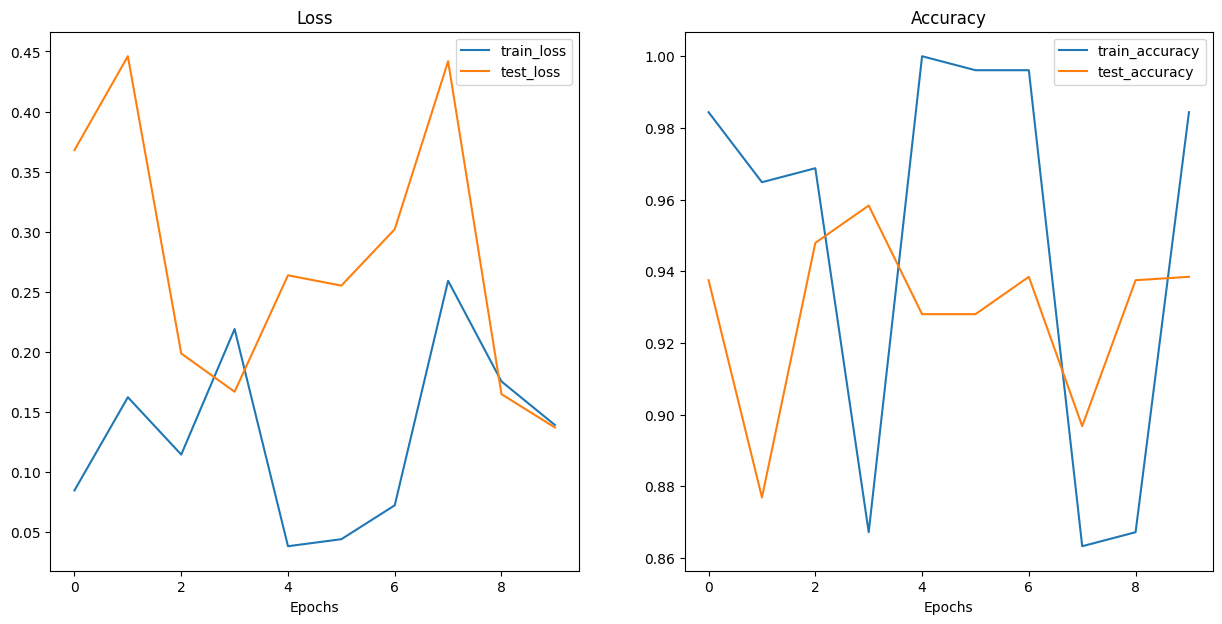

In [28]:
from helper_functions import plot_loss_curves
plot_loss_curves(effnetb2_results)

### 3.5 Saving EffNetB2 feature extractor

In [29]:
from going_modular.going_modular import utils

# Save the model
utils.save_model(model=effnetb2,
                 target_dir='models',
                 model_name="09_pretrained_effnetb2_feature_extractor_pizza_steak_sushi_20_percent.pth")

[INFO] Saving model to: models/09_pretrained_effnetb2_feature_extractor_pizza_steak_sushi_20_percent.pth


### 3.6. Inspecting the size of our EffNetB2 feature extractor